<a href="https://colab.research.google.com/github/mannam95/Deep_Learning_Programming/blob/main/Assignment5/Assignment_5_RNN_Part1_Srinath.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Team Assignment


1.   Srinath Mannam (229750)
2.   Meghana Rao (234907)
3.   Govind Shukla (235192)

# import statements

In [1]:
import os
import tensorflow as tf
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
import sys
import tensorflow.keras.backend as K
from tensorflow.python.keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
import pydot
import graphviz
from keras.callbacks import ModelCheckpoint
from datetime import datetime
from keras.preprocessing import sequence

# Change the directory

In [2]:
working_directory = '/content/drive/My Drive/Colab Notebooks/OVGU/Deep_Learning/05_Assignment'
def colabDrive():
    from google.colab import drive
    drive.mount("/content/drive")

    if os.getcwd() !=  working_directory:
      os.chdir(working_directory)
    print(os.getcwd())

In [3]:
#colabDrive()

# Clears GPU memory

In [4]:
def clearGPUMemory():
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()
    !nvidia-smi

In [5]:
#clearGPUMemory()

# Prepare the data

## Load the dataset and remove infrequent words

In [6]:
num_words = 40000
(train_sequences, train_labels), (test_sequences, test_labels) = tf.keras.datasets.imdb.load_data(num_words=num_words)

print('Loaded dataset with {} training samples, {} test samples'.format(len(train_sequences), len(test_sequences)))

17473536/17464789 [==============================] - 0s 0us/step
Loaded dataset with 25000 training samples, 25000 test samples


## Have some look at train dataset

In [7]:
# look at some sequences. words have been replaced with arbitrary index mappings
# 1 is a special "beginning of sequence" marker
# infrequent words have been replaced by the index 2
# actual words start with index 4, 3 is never used (???)
train_sequences[:3]

array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]),
       list([1, 194, 1

In [8]:
print('---review---')
print(train_sequences[6])
print('---label---')
print(train_labels[6])

---review---
[1, 6740, 365, 1234, 5, 1156, 354, 11, 14, 5327, 6638, 7, 1016, 10626, 5940, 356, 44, 4, 1349, 500, 746, 5, 200, 4, 4132, 11, 16393, 9363, 1117, 1831, 7485, 5, 4831, 26, 6, 2, 4183, 17, 369, 37, 215, 1345, 143, 32677, 5, 1838, 8, 1974, 15, 36, 119, 257, 85, 52, 486, 9, 6, 26441, 8564, 63, 271, 6, 196, 96, 949, 4121, 4, 2, 7, 4, 2212, 2436, 819, 63, 47, 77, 7175, 180, 6, 227, 11, 94, 2494, 33740, 13, 423, 4, 168, 7, 4, 22, 5, 89, 665, 71, 270, 56, 5, 13, 197, 12, 161, 5390, 99, 76, 23, 2, 7, 419, 665, 40, 91, 85, 108, 7, 4, 2084, 5, 4773, 81, 55, 52, 1901]
---label---
1


## to restore words, load the word-to-index mapping

In [9]:
word2id = tf.keras.datasets.imdb.get_word_index()
id2word = {i: word for word, i in word2id.items()}
print('---review with words---')
print([id2word.get(i, ' ') for i in train_sequences[6]])
print('---label---')
print(train_sequences[6])
print('---label---')
print(train_labels[6])

1654784/1641221 [==============================] - 0s 0us/step
---review with words---
['the', 'boiled', 'full', 'involving', 'to', 'impressive', 'boring', 'this', 'as', 'murdering', 'naschy', 'br', 'villain', 'council', 'suggestion', 'need', 'has', 'of', 'costumes', 'b', 'message', 'to', 'may', 'of', 'props', 'this', 'echoed', 'concentrates', 'concept', 'issue', 'skeptical', 'to', "god's", 'he', 'is', 'and', 'unfolds', 'movie', 'women', 'like', "isn't", 'surely', "i'm", 'rocketed', 'to', 'toward', 'in', "here's", 'for', 'from', 'did', 'having', 'because', 'very', 'quality', 'it', 'is', "captain's", 'starship', 'really', 'book', 'is', 'both', 'too', 'worked', 'carl', 'of', 'and', 'br', 'of', 'reviewer', 'closer', 'figure', 'really', 'there', 'will', 'originals', 'things', 'is', 'far', 'this', 'make', 'mistakes', "kevin's", 'was', "couldn't", 'of', 'few', 'br', 'of', 'you', 'to', "don't", 'female', 'than', 'place', 'she', 'to', 'was', 'between', 'that', 'nothing', 'dose', 'movies', 'get

## Maximum review length and minimum review length.

In [10]:
print('Maximum review length: {}'.format(len(max((train_sequences + test_sequences), key=len))))

Maximum review length: 2697


In [11]:
print('Minimum review length: {}'.format(len(min((train_sequences + test_sequences), key=len))))

Minimum review length: 70


## Overview over the sequence length in the data

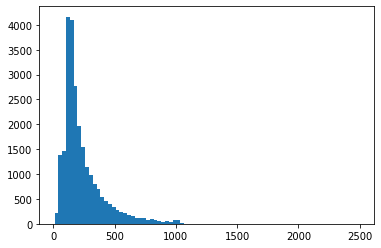

In [12]:
sequence_lengths = [len(sequence) for sequence in train_sequences]
max_len = max(sequence_lengths)
max_len

plt.hist(sequence_lengths, bins=80)
plt.show()

## Pad Sequences  to some length because the dataset should be in rectangular for feeding to tensors

*  all sequences above maxlen will be truncated to that length
*  note: pad_sequences has "pre" and "post" options for both padding and truncation. one may be better than the other!

In [13]:
max_words = 500
train_sequences = sequence.pad_sequences(train_sequences, maxlen=max_words, padding = "post", truncating = "pre")
test_sequences = sequence.pad_sequences(test_sequences, maxlen=max_words, padding = "post", truncating = "pre")

## Load the dataset into tensors

In [14]:
train_labels = train_labels.reshape(-1).astype(np.int32)
test_labels = test_labels.reshape(-1).astype(np.int32)
# train_data = tf.data.Dataset.from_tensor_slices((train_sequences, train_labels))
# test_data = tf.data.Dataset.from_tensor_slices((test_sequences, test_labels))

train_data = tf.data.Dataset.from_tensor_slices((train_sequences, train_labels)).shuffle(25000).batch(128, drop_remainder=True)
test_data = tf.data.Dataset.from_tensor_slices((test_sequences, test_labels)).batch(128, drop_remainder=True)

In [15]:
print("Training Dataset Size: ",train_sequences.shape)
print("Test Dataset Size: ",test_sequences.shape)

Training Dataset Size:  (25000, 500)
Test Dataset Size:  (25000, 500)


# Models Config

## Model1 Config

In [16]:
modelConfig1 = {
    "epochs" : 10,
    "learning_rate" : 0.1,

    ##Input to hidden(U)
    "W_Inp_Hid":  tf.Variable(tf.random.uniform([20000, 64], minval=-0.1, maxval=0.1, dtype=np.float32)),
    ##Initial Previous hidden(ht-1)
    "Init_Prev_Hidden":  tf.Variable(np.zeros([1,64], dtype=np.float32)),
    ##Hidden to hidden(W)
    "W_Hid_Hid":  tf.Variable(tf.random.uniform([64, 64], minval=-0.1, maxval=0.1, dtype=np.float32)),
    ##bias(b)
    "b": tf.Variable(np.zeros((1, 64), dtype=np.float32)),
    ##Hidden to hidden(W)
    "W_Hid_Out":  tf.Variable(tf.random.uniform([64, 2], minval=-0.1, maxval=0.1, dtype=np.float32)),
    ##bias(c)
    "c": tf.Variable(np.zeros((128, 2), dtype=np.float32))
}

## Model2 Config

In [17]:
modelConfig2 = {
    "epochs" : 40,
    "learning_rate" : 0.001,

    ##Input to hidden(U)
    "W_Inp_Hid":  tf.Variable(tf.random.uniform([num_words, 128], minval=-0.1, maxval=0.1, dtype=np.float32)),
    ##Initial Previous hidden(ht-1)
    "Init_Prev_Hidden":  tf.Variable(np.zeros([1,128], dtype=np.float32)),
    ##Hidden to hidden(W)
    "W_Hid_Hid":  tf.Variable(tf.random.uniform([128, 128], minval=-0.1, maxval=0.1, dtype=np.float32)),
    ##bias(b)
    "b": tf.Variable(np.zeros((1, 128), dtype=np.float32)),
    ##Hidden to hidden(V)
    "W_Hid_Out":  tf.Variable(tf.random.uniform([128, 2], minval=-0.1, maxval=0.1, dtype=np.float32)),
    ##bias(c)
    "c": tf.Variable(np.zeros((128, 2), dtype=np.float32))
}

## Model3 Config

In [ ]:
modelConfig3 = {
    "epochs" : 20,
    "learning_rate" : 0.001,

    ##Input to hidden(U)
    "W_Inp_Hid":  tf.Variable(tf.random.uniform([num_words, 128], minval=-0.2, maxval=0.2, dtype=np.float32)),
    ##Initial Previous hidden(ht-1)
    "Init_Prev_Hidden":  tf.Variable(np.zeros([1,128], dtype=np.float32)),
    ##Hidden to hidden(W)
    "W_Hid_Hid":  tf.Variable(tf.random.uniform([128, 128], minval=-0.2, maxval=0.2, dtype=np.float32)),
    ##bias(b)
    "b": tf.Variable(np.zeros((1, 128), dtype=np.float32)),
    ##Hidden to hidden(V)
    "W_Hid_Out":  tf.Variable(tf.random.uniform([128, 2], minval=-0.2, maxval=0.2, dtype=np.float32)),
    ##bias(c)
    "c": tf.Variable(np.zeros((128, 2), dtype=np.float32))
}

# Generic Function for training, testing

## RNN Loop Cell

In [18]:
def rnn_loop(sequences, modelConfig):
    old_state = modelConfig['Init_Prev_Hidden']
    #seq_onehot = tf.one_hot(sequences, depth=num_words)

    for step in range(max_words):
        #x_t = seq_onehot[:,step]
        x_t = sequences[:, step]
        x_t = tf.one_hot(x_t, depth=num_words)
        at = modelConfig['b'] + tf.matmul(old_state, modelConfig['W_Hid_Hid']) + tf.matmul(x_t, modelConfig['W_Inp_Hid'])
        new_state = tf.nn.tanh(at)
        old_state = new_state

    o_t = modelConfig['c'] + tf.matmul(new_state, modelConfig['W_Hid_Out'])

    return o_t

## Training and Test Loop

In [19]:
def train_loop(modelConfig):
    optimizer = tf.keras.optimizers.Adam(learning_rate=modelConfig['learning_rate'])
    for epoch in range(modelConfig['epochs']):
      print("Epoch No: ", epoch)
      for step, (sequence_batch, label_batch) in enumerate(train_data):
          # label_batch = tf.reshape(label_batch, [1])
          with tf.GradientTape() as tape:
              logits = rnn_loop(sequence_batch, modelConfig)
              xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
                  logits=logits, labels=label_batch))

          ## Gradients calculation and update weights
          grads = tape.gradient(xent, [modelConfig['W_Inp_Hid'], modelConfig['W_Hid_Hid'], modelConfig['b'], modelConfig['W_Hid_Out'], modelConfig['c']])
          optimizer.apply_gradients(zip(grads, [modelConfig['W_Inp_Hid'], modelConfig['W_Hid_Hid'], modelConfig['b'], modelConfig['W_Hid_Out'], modelConfig['c']]))


          if not step % 50:
              print("Steps Completed: ", step)
              preds = tf.argmax(logits, axis=1, output_type=tf.int32)
              acc = tf.reduce_mean(tf.cast(tf.equal(preds, label_batch), tf.float32))
              print("Loss: {} Accuracy: {}".format(xent, acc))
          
      print("-------------\n")

    #Testing
    print("Working on test dataset")
    testAcc = []
    for step, (sequence_batch, label_batch) in enumerate(test_data):
        if not step % 50:
          print("Steps Completed: ", step)
        logits = rnn_loop(sequence_batch, modelConfig)
        preds = tf.argmax(logits, axis=1, output_type=tf.int32)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, label_batch), tf.float32))
        testAcc.append(acc)

    print("Final Test Accuracy Average: {} ".format(sum(testAcc)/len(testAcc)))


# Different Models Running



## Model1

1.   With 10 Epochs
2.   The test accuracy is 49.6%
3.   Batch Size of 128
4.   Hidden layer neurons are 64
5.   Max corpus length 20000
6.   Max words 300, padding post, truncating post

In [ ]:
train_loop(modelConfig1)

Epoch No:  0
Steps Completed:  0
Loss: 0.696199357509613 Accuracy: 0.4609375
Steps Completed:  50
Loss: 0.9726694822311401 Accuracy: 0.484375
Steps Completed:  100
Loss: 0.7283741235733032 Accuracy: 0.53125
Steps Completed:  150
Loss: 0.746300995349884 Accuracy: 0.53125
-------------

Epoch No:  1
Steps Completed:  0
Loss: 0.8708627223968506 Accuracy: 0.5703125
Steps Completed:  50
Loss: 0.7043036818504333 Accuracy: 0.5546875
Steps Completed:  100
Loss: 0.8352829217910767 Accuracy: 0.484375
Steps Completed:  150
Loss: 0.7988328337669373 Accuracy: 0.5390625
-------------

Epoch No:  2
Steps Completed:  0
Loss: 0.6984706521034241 Accuracy: 0.5859375
Steps Completed:  50
Loss: 0.6942040920257568 Accuracy: 0.59375
Steps Completed:  100
Loss: 0.6530992388725281 Accuracy: 0.609375
Steps Completed:  150
Loss: 0.8190151453018188 Accuracy: 0.46875
-------------

Epoch No:  3
Steps Completed:  0
Loss: 0.7579739093780518 Accuracy: 0.5234375
Steps Completed:  50
Loss: 0.7478058934211731 Accuracy: 

## Model2

1.   With 40 Epochs
2.   The test accuracy is 50.6%
3.   Batch Size of 128
4.   Hidden layer neurons are 128
5.   Max corpus length 40000
6.   Max words 500, padding post, truncating pre

In [21]:
train_loop(modelConfig2)

Epoch No:  0
Steps Completed:  0
Loss: 0.6928707957267761 Accuracy: 0.578125
Steps Completed:  50
Loss: 0.6919717788696289 Accuracy: 0.5078125
Steps Completed:  100
Loss: 0.6927862763404846 Accuracy: 0.46875
Steps Completed:  150
Loss: 0.6956644058227539 Accuracy: 0.5
-------------

Epoch No:  1
Steps Completed:  0
Loss: 0.6871331334114075 Accuracy: 0.484375
Steps Completed:  50
Loss: 0.6924787759780884 Accuracy: 0.5078125
Steps Completed:  100
Loss: 0.6678862571716309 Accuracy: 0.578125
Steps Completed:  150
Loss: 0.6944794654846191 Accuracy: 0.5078125
-------------

Epoch No:  2
Steps Completed:  0
Loss: 0.6982626914978027 Accuracy: 0.453125
Steps Completed:  50
Loss: 0.6907624006271362 Accuracy: 0.6015625
Steps Completed:  100
Loss: 0.6890923976898193 Accuracy: 0.515625
Steps Completed:  150
Loss: 0.681374192237854 Accuracy: 0.59375
-------------

Epoch No:  3
Steps Completed:  0
Loss: 0.6838294267654419 Accuracy: 0.4921875
Steps Completed:  50
Loss: 0.6668428778648376 Accuracy: 0.5

## Model3

1.   With 20 Epochs
2.   The test accuracy is 50.2%
3.   Batch Size of 128
4.   Hidden layer neurons are 128
5.   Max corpus length 40000
6.   Max words 500, padding post, truncating pre
7.   Weights are initialised from -0.2 to 0.2

In [ ]:
train_loop(modelConfig3)

Epoch No:  0
Steps Completed:  0
Loss: 0.7625614404678345 Accuracy: 0.5078125
Steps Completed:  50
Loss: 0.6968785524368286 Accuracy: 0.453125
Steps Completed:  100
Loss: 0.6926401853561401 Accuracy: 0.46875
Steps Completed:  150
Loss: 0.6837975382804871 Accuracy: 0.625
-------------

Epoch No:  1
Steps Completed:  0
Loss: 0.6936752200126648 Accuracy: 0.5234375
Steps Completed:  50
Loss: 0.6903246641159058 Accuracy: 0.5234375
Steps Completed:  100
Loss: 0.7023606896400452 Accuracy: 0.46875
Steps Completed:  150
Loss: 0.7186465263366699 Accuracy: 0.4296875
-------------

Epoch No:  2
Steps Completed:  0
Loss: 0.6824567914009094 Accuracy: 0.59375
Steps Completed:  50
Loss: 0.6933882236480713 Accuracy: 0.5078125
Steps Completed:  100
Loss: 0.6863447427749634 Accuracy: 0.5234375
Steps Completed:  150
Loss: 0.704568088054657 Accuracy: 0.484375
-------------

Epoch No:  3
Steps Completed:  0
Loss: 0.6739521026611328 Accuracy: 0.59375
Steps Completed:  50
Loss: 0.6993414163589478 Accuracy: 0.

# Questions

# Q1

Question:



*   In the notebook, this is done in a rather crude way: All sequences are padded to the length of the longest sequence in the dataset.
*   Why is this wasteful? Can you think of a smarter padding scheme that is more efficient? Consider the fact that RNNs can work on arbitrary sequence lengths, and that training minibatches are pretty much independent of each other

Answer: 



*   Because as per the histogram plot in the above plots, we can see that most of the sequence lengths are between 0-500 and if we pad to the max length then most of the neurons are initialised with dummy values which is wasteful for computation.
*   Alternative way is to pad at batch level by taking the average length of sequences in that particular batch or truncate all sequences to some length like 500 and pad.





# Q2

Question: Between truncating long sequences and removing them, which option do you think is better? Why?

Answer: Pre truncating and post-padding is bettter.





# Q3

Question: Can you think of a way to avoid the one-hot vectors completely? Even if you cannot implement it, a conceptual idea is fine.

Answer: Word embeddings.





# Q4

Question: How can it be that we can choose how many outputs we have, i.e. how can both be correct? Are there differences between both choices as well as (dis)advantages relative to each other?

Answer: Word embeddings.





# Q5

Question: All sequences start with the same special “beginning of sequence” token (coded by index 1). Given this fact, is there a point in learning an initial state? Why (not)?

Answer: Word embeddings.





# Q6

Question: pad_sequences allows for pre or post padding. Try both to see the difference. Which option do you think is better? Recall that we use the final time step output from our model.

Answer: Word embeddings.





# Q7

Question: Can you think of a way to prevent the RNN from computing new states on padded time steps? One idea might be to “pass through” the previous state in case the current time step is padding. Note that, within a batch, some sequences might be padded for a given time step while others are not.

Answer: Word embeddings.





# References


1.   https://towardsdatascience.com/a-beginners-guide-on-sentiment-analysis-with-rnn-9e100627c02e
2.   List item

